# Image Search

## Environment Setup

We first need to setup our environment, we need HuggingFace Datasets for our data and the MyScale clients.

In [1]:
!pip install datasets myscaledb-client

## Populate data to MyScale

### Load Data

Then we load data from HuggingFace Dataset [qingdi/unsplash-25k-examples](https://huggingface.co/datasets/qingdi/unsplash-25k-examples/tree/main), which is created from [unsplash-25K](https://huggingface.co/datasets/jamescalam/unsplash-25k-photos) datasets.

`photo_embed` is a 512-dimensional floating-point vector that represents the image features extracted from an image using the [CLIP](https://huggingface.co/openai/clip-vit-base-patch32) model. This vector is generated using the feature extraction method implemented in [helper.ipynb](helper.ipynb).

In [2]:
from datasets import load_dataset

photos = load_dataset("qingdi/unsplash-25k-examples", data_files="photos.parquet", split="train")
conversions = load_dataset("qingdi/unsplash-25k-examples", data_files="conversions.parquet", split="train")

Using custom data configuration qingdi--unsplash-25k-examples-2dbef283c213eff3


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /Users/qingdizhang/.cache/huggingface/datasets/qingdi___parquet/qingdi--unsplash-25k-examples-2dbef283c213eff3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Using custom data configuration qingdi--unsplash-25k-examples-0911848b2e23f999


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /Users/qingdizhang/.cache/huggingface/datasets/qingdi___parquet/qingdi--unsplash-25k-examples-0911848b2e23f999/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [3]:
# transform datasets to panda Dataframe
photo_df = photos.to_pandas()
conversion_df = conversions.to_pandas()

# convert photo_embed from np array to list
photo_df['photo_embed'] = photo_df['photo_embed'].apply(lambda x: x.tolist())

In [4]:
photo_df.head()

,photo_id,photo_image_url,photo_embed
0,XMyPniM9LF0,https://images.unsplash.com/uploads/1411949294...,"[-0.02423190325498581, 0.05229705199599266, 0...."
1,rDLBArZUl1c,https://images.unsplash.com/photo-141633941111...,"[-0.032578177750110626, 0.028756439685821533, ..."
2,cNDGZ2sQ3Bo,https://images.unsplash.com/photo-142014251503...,"[-0.03327571600675583, 0.051595136523246765, 0..."
3,iuZ_D1eoq9k,https://images.unsplash.com/photo-141487280988...,"[0.008161935955286026, 0.00707155792042613, -0..."
4,BeD3vjQ8SI0,https://images.unsplash.com/photo-141700759404...,"[-0.01028392929583788, -0.0009960911702364683,..."


In [5]:
conversion_df.head()

,photo_id,keyword,conversion_country
0,Knwea-mLGAg,starry sky,TW
1,AZMmUy2qL6A,camping,KR
2,agE97zp_Xvo,lonely,IN
3,EXbGG5dBZKw,happy,CN
4,EWDvHNNfUmQ,wood,EC


### Create Table & Upload Data

Next, we create a table and vector index in MyScale. To complete this step, you will need to retrieve your cluster URL, username, and password information from the MyScale console.

In [6]:
from myscaledb import Client

# initialize MyScale client
client = Client(url="{url}", user="{user}", password="{passwd}")

assert client.is_alive()

In [7]:
# drop table if existed
client.execute("DROP TABLE IF EXISTS default.photos")
client.execute("DROP TABLE IF EXISTS default.conversions")

In [8]:
# create table
client.execute("""
CREATE TABLE default.photos
(
    id UInt64,
    photo_id String,
    photo_url String,
    photo_embed Array(Float32),
    CONSTRAINT vector_len CHECK length(photo_embed) = 512
)
ENGINE = MergeTree ORDER BY id
""")

client.execute("""
CREATE TABLE default.conversions
(
    id UInt64,
    photo_id String,
    keyword String,
    conversion_country String
)
ENGINE = MergeTree ORDER BY id
""")

res = client.fetch(query="SHOW TABLES")
print([row[0] for row in res])

['conversions', 'photos']


In [9]:
# upload data from datasets

client.execute("INSERT INTO default.photos VALUES", photo_df.to_records(index=True).tolist())
client.execute("INSERT INTO default.conversions VALUES", conversion_df.to_records(index=True).tolist())

print(f"photos count: {client.fetchval(query='SELECT count(*) FROM default.photos')}")
print(f"conversions count: {client.fetchval(query='SELECT count(*) FROM default.conversions')}")

photos count: 963
conversions count: 607209


In [10]:
# create vector index with cosine
client.execute("""
ALTER TABLE default.photos 
ADD VECTOR INDEX photo_embed_index photo_embed
TYPE HNSWFLAT
('metric_type=Cosine')
""")

In [11]:
# make sure vector index is ready with 'Built' status
get_index_status="SELECT status FROM system.vector_indices WHERE table='photos'"
print(f"index build status: {client.fetchval(query=get_index_status)}")

index build status: Built


## Query

### Find top K similar images

First, let's randomly select an image and display it. Then, using vector search, we will identify the top K candidates that are most similar to this image, and display all of the these candidates.

In [12]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def show_image(url, title=None):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    fig = plt.figure(figsize=(4, 4))

    plt.imshow(img)
    plt.show()

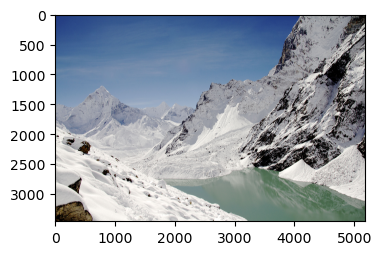

In [15]:
# pick a random image
import random

img_id = random.randint(0, len(photo_df)-1)
url = photo_df.loc[img_id, 'photo_image_url']
show_image(url)

In [16]:
query_photo = photo_df.loc[img_id, 'photo_id']
query_embed = photo_df.loc[img_id, 'photo_embed']

top_k = 5
results = client.fetch("""
SELECT photo_id, distance('topK={top_k}')(photo_embed, {query_embed}) as dist
FROM default.photos
WHERE photo_id != '{query_id}'
""".format(top_k=top_k, query_embed=query_embed, query_id=query_photo))

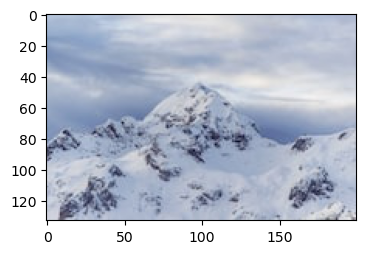

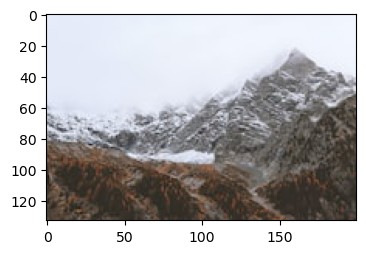

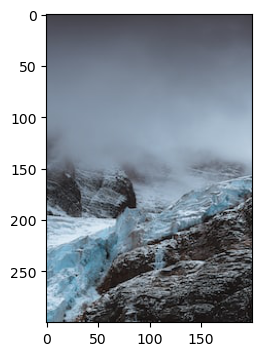

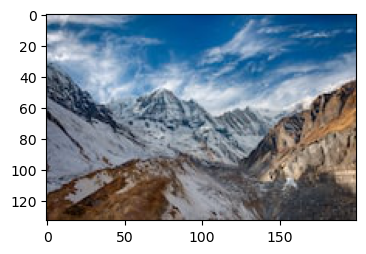

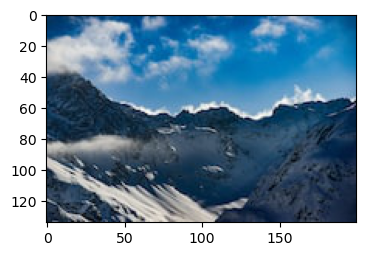

In [18]:
for r in results:
    # construct a URL to download an image with a smaller size by modifying the image URL
    url = photo_df.loc[photo_df['photo_id'] == r[0], 'photo_image_url'].item() + "?q=75&fm=jpg&w=200&fit=max"
    show_image(url)

### Analyze conversion information for each candidates

Next, we will analyze these candidate images. We'll begin by calculating the total conversion count for each candidate. Once we've identified the candidate with the most downloads, we'll examine the detailed conversion information per country for that image.

In [19]:
top_k = 5
results = client.fetch("""
SELECT photo_id, count(*) as count
FROM default.conversions
JOIN default.photos
ON default.conversions.photo_id = default.photos.photo_id
WHERE photo_id IN (
    SELECT photo_id FROM (
        SELECT photo_id, distance('topK={top_k}')(photo_embed, {query}) as dist
        FROM default.photos
        ORDER BY dist DESC
    )
    LIMIT {top_k}
)
GROUP BY photo_id
ORDER BY count DESC
""".format(top_k=top_k, query=query_embed))

print("Total downloads for each candidate")
for r in results:
    print("- {}: {}".format(r[0], r[1]))

Total downloads for each candidate
- BLTcKiKXbzU: 1338
- 94sVs1D3Vvw: 239
- ep6buhlUofU: 181
- gVG5k5u1Cxw: 176
- uaQI3BI8ZrA: 66


In [20]:
most_popular_candidate = results[0][0]

top_k = 10
results = client.fetch("""
SELECT conversion_country, count(*) as count
FROM default.conversions
WHERE photo_id='{}'
GROUP BY conversion_country
ORDER BY count DESC
LIMIT 5
""".format(most_popular_candidate))

print("Downloads for '{}':".format(most_popular_candidate))
for r in results:
    print("- {}: {}".format(r[0], r[1]))

Downloads for 'BLTcKiKXbzU':
- BR: 297
- FR: 204
- ID: 76
- IN: 51
- IT: 50
